In [2]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb
from scipy.stats import randint, loguniform, uniform
import numpy as np

In [3]:
df = pd.read_csv(r'/workspaces/carlos060495-intro-ml/data/raw/medical_insurance_cost.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 1.1 Busqueda y eliminacion datos unicos

In [5]:
unicos = df.nunique()
unicos

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [6]:
df[unicos[unicos == 1].index]

""
0
1
2
3
4
...
1333
1334
1335
1336


No se encontraron con valores unicos

# 1.2 Busqueda y eliminacion datos duplicados en filas y columnas

In [7]:
df.duplicated().sum()

np.int64(1)

In [8]:
df[df.duplicated(keep=False)]


,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [9]:
# Se encontro una fila duplicada y se procede a su eliminacion
df = df.drop_duplicates()
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [10]:
df.T.duplicated().sum()

np.int64(0)

No se encontraron columnas con valores duplicados

# 1.3 Busqueda de valores faltantes y nulos

In [11]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# 1.3.1 Busqueda profunda de valores faltantes

In [12]:
# Ahora vamos a ver que valores únicos tiene cada columna de texto. Esto nos ayudará a identificar valores sospechosos.
for columna in df.select_dtypes(include='object').columns: # → Recorre todas las columnas de texto
    print(f"\n{'-'*25}")
    print(f"COLUMNA: {columna}")
    print(f"{'-'*25}")
    print(df[columna].value_counts()) # Muestra cada valor único y cuántas veces aparece, ordenado de mayor a menor frecuencia
    print(f"\nTotal de valores únicos: {df[columna].nunique()}") # → Cuenta cuántos valores diferentes hay en total


-------------------------
COLUMNA: sex
-------------------------
sex
male      675
female    662
Name: count, dtype: int64

Total de valores únicos: 2

-------------------------
COLUMNA: smoker
-------------------------
smoker
no     1063
yes     274
Name: count, dtype: int64

Total de valores únicos: 2

-------------------------
COLUMNA: region
-------------------------
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

Total de valores únicos: 4


En la busqueda profunda no se encontraron faltantes ocultos

<Axes: >

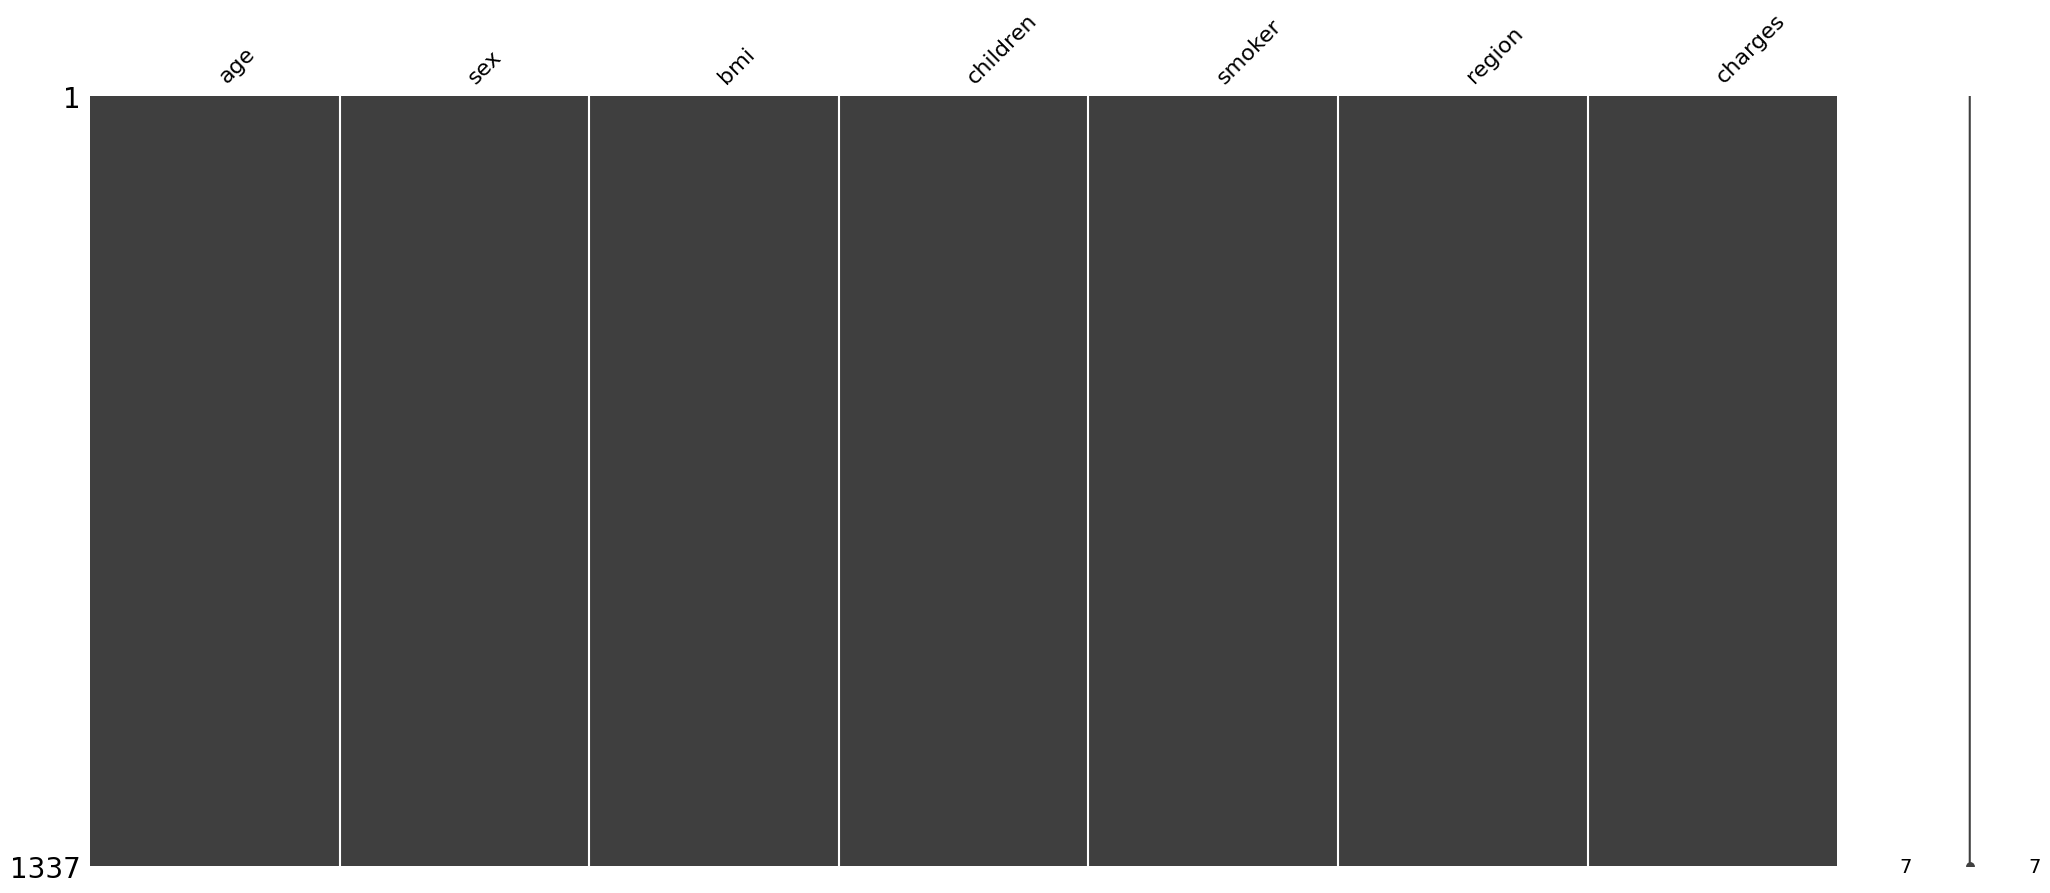

In [13]:
msno.matrix(df)

# 2.1 Codificacion de variables categoricas

In [14]:
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True, dtype=int)
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


# 2.2 Outliers

In [15]:
# ============================================================================
# CALCULAR OUTLIERS DE FORMA SENCILLA (Método IQR)
# ============================================================================

# Lista de columnas que quiero analizar
columnas = ['age', 'bmi', 'children']

# Para guardar los resultados
resultados = []

# Analizar cada columna una por una
for columna in columnas:
    
    # Obtener los datos de la columna
    datos = df[columna]
    
    # Calcular Q1 (25%), Q3 (75%) y IQR
    Q1 = datos.quantile(0.25)  # 25% de los datos
    Q3 = datos.quantile(0.75)  # 75% de los datos
    IQR = Q3 - Q1              # Diferencia entre Q3 y Q1
    
    # Calcular límites
    limite_bajo = Q1 - 1.5 * IQR
    limite_alto = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_bajos = (datos < limite_bajo).sum()
    outliers_altos = (datos > limite_alto).sum()
    total_outliers = outliers_bajos + outliers_altos
    
    # Calcular porcentaje
    porcentaje = (total_outliers / len(datos)) * 100
    
    # Guardar en la lista
    resultados.append({
        'Columna': columna,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite_Bajo': limite_bajo,
        'Limite_Alto': limite_alto,
        'Total_Outliers': total_outliers,
        'Porcentaje': round(porcentaje, 2)
    })

# Convertir a DataFrame para verlo bonito
df_outliers = pd.DataFrame(resultados)

# Mostrar resultados
print("="*80)
print("ANÁLISIS DE OUTLIERS")
print("="*80)
print(df_outliers)
print("="*80)

# Explicar qué significa
print("\n💡 INTERPRETACIÓN:")
for i in range(len(df_outliers)):
    col = df_outliers.loc[i, 'Columna']
    limite_bajo = df_outliers.loc[i, 'Limite_Bajo']
    limite_alto = df_outliers.loc[i, 'Limite_Alto']
    total = df_outliers.loc[i, 'Total_Outliers']
    pct = df_outliers.loc[i, 'Porcentaje']
    
    print(f"\n{col}:")
    print(f"  - Valores normales: entre {limite_bajo:.1f} y {limite_alto:.1f}")
    print(f"  - Outliers encontrados: {total} ({pct}%)")
    
    if pct < 5:
        print(f"  ✅ Pocos outliers, está bien")
    elif pct < 10:
        print(f"  ⚠️ Algunos outliers")
    else:
        print(f"  ❌ Muchos outliers")

ANÁLISIS DE OUTLIERS
    Columna     Q1    Q3    IQR  Limite_Bajo  Limite_Alto  Total_Outliers  \
0       age  27.00  51.0  24.00       -9.000       87.000               0   
1       bmi  26.29  34.7   8.41       13.675       47.315               9   
2  children   0.00   2.0   2.00       -3.000        5.000               0   

   Porcentaje  
0        0.00  
1        0.67  
2        0.00  

💡 INTERPRETACIÓN:

age:
  - Valores normales: entre -9.0 y 87.0
  - Outliers encontrados: 0 (0.0%)
  ✅ Pocos outliers, está bien

bmi:
  - Valores normales: entre 13.7 y 47.3
  - Outliers encontrados: 9 (0.67%)
  ✅ Pocos outliers, está bien

children:
  - Valores normales: entre -3.0 y 5.0
  - Outliers encontrados: 0 (0.0%)
  ✅ Pocos outliers, está bien


# 3.1 Verificacion para regresion lineal

In [16]:
X = df_encoded.drop(columns='charges')
y = df_encoded['charges']


In [17]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.0
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:52:34   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1328   BIC:                         2.714e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    988.227  

In [18]:
residuos = results.resid

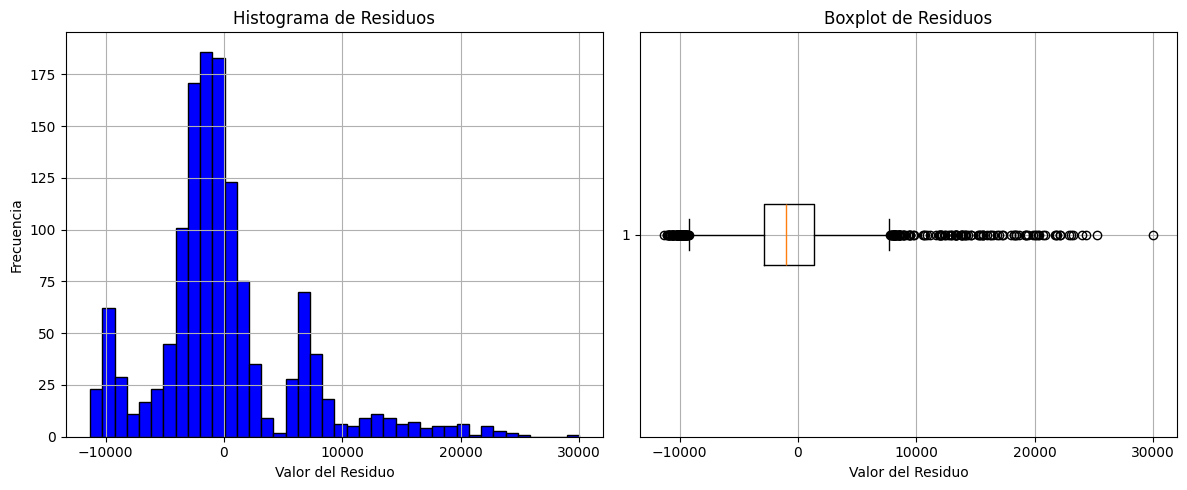

In [19]:
# Crea una figura con dos subgráficos (uno para el histograma y otro para el boxplot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de los residuos en el primer subgráfico (ax1)
ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

# Boxplot de los residuos en el segundo subgráfico (ax2)
ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

# Muestra la figura con ambos gráficos
plt.tight_layout()  # Ajusta los márgenes para evitar superposiciones
plt.show()

# 4.1 Division de los datos para entrenamiento y test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 4.2 Seleccion de caracteristicas

He decidido mantener todas las características en el modelado porque cada variable aporta información complementaria sobre los costes médicos. Las numéricas continuas reflejan tendencias de salud y edad, mientras que las categóricas codificadas capturan diferencias relevantes entre grupos de pacientes, como el hábito de fumar o la región de residencia. Incluso aquellas variables que parecen menos influyentes pueden contribuir a mejorar la capacidad predictiva del modelo, por lo que conservarlas garantiza un análisis más completo y robusto.

# 4.3 Escalado

In [21]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 4.4 Entrenamos el Modelo y realizamos pruebas

In [22]:
# Entrenamos un modelo de regresión lineal sin regularización
m_linear = LinearRegression().fit(X_train_sc, y_train)

# Realizamos predicciones sobre el conjunto de entrenamiento y de testeo
yhat_train_linear = m_linear.predict(X_train_sc)
yhat_linear = m_linear.predict(X_test_sc)

# 4.5 Obtenemos las metricas de las pruebas realizadas

In [23]:
def get_metrics(yhat, y_test, yhat_train, y_train):
  metrics_train = r2_score(y_train, yhat_train), median_absolute_error(y_train, yhat_train), mean_absolute_percentage_error(y_train, yhat_train)*100
  metrics_test = r2_score(y_test, yhat), median_absolute_error(y_test, yhat), mean_absolute_percentage_error(y_test, yhat)*100
  metrics_diff = list(map(lambda x: x[1]-x[0], zip(metrics_train, metrics_test)))
  return pd.DataFrame(data=[metrics_train, metrics_test, metrics_diff], columns=['R2', 'Median AE', 'MAPE'], index=['Train set', 'Test set', 'Diferencia'])

In [24]:
get_metrics(yhat_linear, y_test, yhat_train_linear, y_train)

,R2,Median AE,MAPE
Train set,0.748860,2225.724958,40.317138
Test set,0.753039,2164.158234,39.166324
Diferencia,0.004178,-61.566724,-1.150814


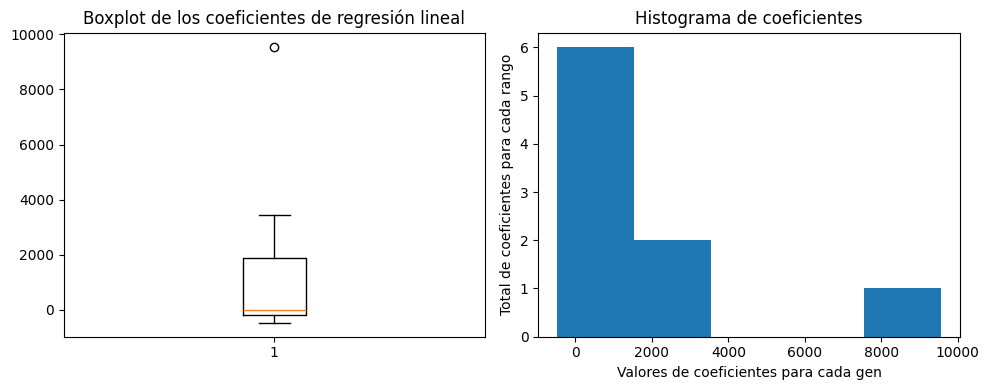

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_linear.coef_)
plt.title('Boxplot de los coeficientes de regresión lineal')
plt.subplot(1, 2, 2)
plt.hist(m_linear.coef_,'sturges')
plt.xlabel('Valores de coeficientes para cada gen')
plt.ylabel('Total de coeficientes para cada rango')
plt.title('Histograma de coeficientes')
plt.tight_layout()
plt.show()

# 5.1 Búsqueda de hiperparámetros 

## 5.1.1 Búsqueda extensiva

In [26]:
# Modelo base
model = LinearRegression()

# Espacio de búsqueda válido para LinearRegression
param_dist = {
    'fit_intercept': [True, False],
    'positive': [True, False],  # fuerza coeficientes positivos
    # 'normalize' ya no se usa en versiones recientes de sklearn
}

# Búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,  # número de combinaciones aleatorias a probar
    scoring='neg_root_mean_squared_error',  # métrica de evaluación
    cv=5,  # validación cruzada con 5 folds
    verbose=4,
    n_jobs=-1,
    random_state=123
)

# Entrenamiento
random_search.fit(X_train_sc, y_train)

# Resultados
print("Mejores hiperparámetros:")
print(random_search.best_params_)

# Mejor modelo encontrado
best_model = random_search.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END fit_intercept=True, positive=True;, score=-5302.120 total time=   0.0s
[CV 2/5] END fit_intercept=True, positive=True;, score=-6413.122 total time=   0.0s
[CV 3/5] END fit_intercept=True, positive=True;, score=-5963.982 total time=   0.0s
[CV 4/5] END fit_intercept=True, positive=True;, score=-5867.357 total time=   0.0s
[CV 5/5] END fit_intercept=True, positive=True;, score=-6384.971 total time=   0.0s
[CV 1/5] END fit_intercept=True, positive=False;, score=-5294.153 total time=   0.0s
[CV 2/5] END fit_intercept=True, positive=False;, score=-6417.631 total time=   0.0s
[CV 3/5] END fit_intercept=True, positive=False;, score=-6014.034 total time=   0.0s
[CV 4/5] END fit_intercept=True, positive=False;, score=-5863.685 total time=   0.0s
[CV 5/5] END fit_intercept=True, positive=False;, score=-6397.001 total time=   0.0s
[CV 1/5] END fit_intercept=False, positive=True;, score=-13862.303 total time=   0.0s
[CV 2/5] END fit_intercept=False, positive=True;, score=-14311.943 to